<center>
# Linear algebra in
<img width=400 src=julia.png>
## Andreas Noack
### April 2015
### Computer Science and Artificial Intelligence Laboratory<br>Massachusetts Institute of Technology
</center>

## Outline
 - What is Julia
  - The people behind
  - Two language problem
 - Introduction to linear algebra
  - Basic linear algebra
  - Factorizations
  - Special matrices
 - Generic linear algebra
 - Fast linear algebra
 - Parallel linear algebra?

## What is Julia
 - Fast
 - Easy
 
### Founded by
 - Alan Edelman
 - Jeff Besanzon
 - Viral B. Shah
 - Stefan Starpinski
<img width=700 src=kahan.jpg>

#### Contributors
As of this Friday
 - 348 contributors to [JuliaLang/julia](https://github.com/JuliaLang/julia)
<img width=700 src=world1.pdf>
Picture by Jiahao Chen

543 packages registered at [JuliaLang/METADATA.jl](http://pkg.julialang.org/)
<img width=700 src=packages.svg>
Picture by Iain Dunning

### Two language problem - Julia is an outlier
Average of running times vs. average of lines to implement micro benchmark for some popular languages
<img width=700 src=SpeedVsLines.png>
Picture by Simon Danisch

### Easy?
Simple syntax with extensive unicode support that allows code to look like math

In [5]:
# eigenvalues
A = randn(3,3) |> t -> t + t'
λ = eigmax(A)
@show det(A - λ*I)

det(A - λ * I) = -1.3109568854903596e-15


-1.3109568854903596e-15

In [6]:
# Fibonacci
f(n) = n < 2 ? 1 : f(n-1) + f(n-2)
for i = 0:10
    println("f($i) = $(f(i))")
end

f(0) = 1
f(1) = 1
f(2) = 2
f(3) = 3
f(4) = 5
f(5) = 8
f(6) = 13
f(7) = 21
f(8) = 34
f(9) = 55
f(10) = 89


## Basic linear algebra
Syntax very similar to MATLAB but there are some important differences. Define a matrix of random normal variates

In [14]:
A = randn(3,3)

3x3 Array{Float64,2}:
 -0.268693   0.202236   0.0742016
  1.22366   -0.901963  -0.541176 
 -0.70963    1.6595    -0.970164 

and a vector of ones

In [15]:
x = ones(3)

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

Notice that $A$ has type Array{Float64,2} but $x$ has type Array{Float64,1}. Julia defines the aliases Vector{Type}=Array{Type,1} and Matrix{Type}=Array{Type,2}. The destinction between vectors and matrices typically causes some confusion when coming from a MATLAB background.

Many of the basic operations are the same as in MATLAB

### Multiplication

In [16]:
b = A*x

3-element Array{Float64,1}:
  0.00774504
 -0.219476  
 -0.0202953 

###Transposition
As in MATLAB `A'` is the conjugate transpose whereas `A.'` is just the transpose

In [17]:
Asym = A + A'

3x3 Array{Float64,2}:
 -0.537385   1.4259   -0.635429
  1.4259    -1.80393   1.11832 
 -0.635429   1.11832  -1.94033 

###Transposed multiplication
Julia allows us to write this without *

In [18]:
Apd = A'A

3x3 Array{Float64,2}:
  2.07312    -2.33567   0.0063032
 -2.33567     3.60837  -1.10686  
  0.0063032  -1.10686   1.23959  

###Solving linear systems 
The problem $Ax=b$ for square $A$ is solved by the \ function.

In [19]:
A\b

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

###Least squares
When A is tall the \ function calculates the least squares solution

In [20]:
A[:,1:2]\b

2-element Array{Float64,1}:
 -0.265282
 -0.125753

The \ function also works for rank deficient least squares problems. In this case, the least squares solution is not unique and Julia returns the solution with smallest norm

In [21]:
[A[:,1] A[:,1]]\b

2-element Array{Float64,1}:
 -0.0618013
 -0.0618013

###Underdetermined systems
Minimum norm solution is returned

In [22]:
A[1:2,:]\b[1:2]

3-element Array{Float64,1}:
  0.0973882
 -0.159354 
  0.891351 

##Factorizations
The `\` function hides how the problem is actually solved. Depending on the dimensions of `A`, different methods are chosen to solve the problem. An intermediate step in the solution is to calculate a factorization of the matrix `A`. Basically, a factorization of `A` is a way of expressing `A` as a product of triangular, unitary and permutation matrices. Julia defines a `Factorization` abstract type and several composite subtypes for actually storing factorizations. A `Factorization` object should be thought of as a representation of the matrix `A`.

###LU
When `A` is square, problem is solved by factorizing the matrix `A=PLU` where `P` is a permutation matrix, `L` is lower triangular unit diagonal and `U` is upper triangular. Julia allows computing the LU factorization and defines a composite factorization type for storing it.

In [23]:
Alu = lufact(A)

Base.LinAlg.LU{Float64,Array{Float64,2}}(3x3 Array{Float64,2}:
  1.22366   -0.901963    -0.541176 
 -0.579923   1.13643     -1.284    
 -0.219581   0.00368039  -0.0399045,[2,3,3],0)

The different parts of the factorization can be extracted by special indexing

In [24]:
Alu[:P]

3x3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0

In [25]:
Alu[:L]

3x3 Array{Float64,2}:
  1.0       0.0         0.0
 -0.579923  1.0         0.0
 -0.219581  0.00368039  1.0

In [26]:
Alu[:U]

3x3 Array{Float64,2}:
 1.22366  -0.901963  -0.541176 
 0.0       1.13643   -1.284    
 0.0       0.0       -0.0399045

We can therefore compute the solution of $Ax=b$ from the factorization

In [27]:
Alu[:U]\(Alu[:L]\(Alu[:P]'b))

3-element Array{Float64,1}:
 7.1357 
 6.33647
 5.61134

However, more importantly the `LU` type allows dispatch and we can solve the system by

In [28]:
Alu\b

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

This could be useful if the same left-hand-side is used for several right-hand-sides. The factorization can also be used for calculating the determinant because $\det(A)=\det(PLU)=\det(P)\det(U)=\pm \prod u_{ii}$ because $U$ is triangular and the sign is determined from $\det(P)$.

In [29]:
det(Alu)

-0.05549142666237573

###QR
When `A` is tall, Julia computes the least squares solution $\hat{x}$ that minimizes $\|Ax-b\|_2$. This can be done by factorizing $A=QR$ where $Q$ is unitary/orthogonal and $R=\left(\begin{smallmatrix}R_0\\0\end{smallmatrix}\right)$ and $R_0$ is upper triangular. With the QR factorization the minimum norm can be expressed
\begin{equation*}
\|Ax-b\|=\|QRx-b\|=\|Q(Rx-Q'b)\|=\|Rx-Q'b\|=\left\|\begin{pmatrix}R_0x-Q_0'b\\Q_1'b\end{pmatrix}\right\|=\|R_0x-Q_0'b\|+\|Q_1'b\|
\end{equation*}
and the problem therefore reduces to solving the square problem $R_0x=Q_0'b$ for $x$.

We can QR factorize the submatrix of the two first columns of $A$ by

In [30]:
Aqr = qrfact(A[:,1:2])

Base.LinAlg.QRCompactWY{Float64,Array{Float64,2}}(3x2 Array{Float64,2}:
  1.43983   -1.62218 
 -0.716209  -0.988386
  0.415346   0.647292,2x2 Array{Float64,2}:
 1.18661       0.748199
 2.23008e-314  1.40946 )

`\` has a method for the QR and the least squares problem is therefore solved with

In [31]:
Aqr\b

2-element Array{Float64,1}:
 -0.265282
 -0.125753

It should be noted that this is *not* the way `A[:,1:2]\b` is solved. In order to handle rank deficient problems Julia uses a QR factorization with pivoting. Pivoting is enabled with a special boolean argument

In [32]:
Aqrp = qrfact([A[:,1] A[:,1]], Val{true})

Base.LinAlg.QRPivoted{Float64,Array{Float64,2}}(3x2 Array{Float64,2}:
  1.43983   1.43983
 -0.716209  0.0    
  0.415346  0.0    ,[1.1866136136861942,0.0],[1,2])

Notice that the type is different now. `\` also has a method for `QRPivoted` and the rank deficient problem is therefore computed

In [33]:
Aqrp\b

2-element Array{Float64,1}:
 -0.0618013
 -0.0618013

Another feature of the QR factorizations is the `Q` types for storing the unitary matrices $Q$. They can be extracted from the different from `QR` types by indexing

In [34]:
Aqr[:Q]

3x3 Base.LinAlg.QRCompactWYQ{Float64,Array{Float64,2}}:
 -0.186614   0.101665  -0.977159  
  0.849864  -0.482269  -0.21248   
 -0.492856  -0.870104   0.00359633

The matrix has a compact internal representation

In [35]:
@show fieldnames(Aqr[:Q])
V = tril(Aqr[:Q].factors, -1)
V[1,1] = V[2,2] = 1
@show V
@show T = Aqr[:Q].T;

# Hence the complete reflector can be computed 
I - V*T*V'

fieldnames(Aqr[:Q]) = [:factors,:T]
V = [1.0 0.0
 -0.7162094478954593 1.0
 0.41534640768219044 0.6472923748261281]
T = Aqr[:Q].T = [1.1866136136861942 0.7481985203904598
 2.2300771885e-314 1.4094557667768748]


3x3 Array{Float64,2}:
 -0.186614   0.101665  -0.977159  
  0.849864  -0.482269  -0.21248   
 -0.492856  -0.870104   0.00359633

Even though the `Q` type is printed as a square matrix, it is in practice representing the  $3\times 2$ version as well. Hence both

In [36]:
Aqr[:Q]*ones(2)

3-element Array{Float64,1}:
 -0.0849483
  0.367594 
 -1.36296  

and

In [37]:
Aqr[:Q]*ones(3)

3-element Array{Float64,1}:
 -1.06211 
  0.155115
 -1.35936 

works, but not

In [38]:
Aqr[:Q]*ones(4)

LoadError: LoadError: DimensionMismatch("vector must have length either 3 or 2")
while loading In[38], in expression starting on line 1

###Eigendecompositions and the SVD(s)

The results from eigendecompositions and singular values decompositions are also stored in `Factorization` types. This also include Hessenberg and Schur factorizations.

The eigendecomposition can be computed

In [39]:
AsymEig = eigfact(Asym)

Base.LinAlg.Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}([-3.6795142370522607,-0.9949308365043217,0.3928066597554707],3x3 Array{Float64,2}:
  0.428928  -0.361117  0.828019 
 -0.68039    0.473802  0.559089 
  0.594214   0.803185  0.0424731)

The values and the vectors can be extracted from the Eigen type by special indexing

In [40]:
AsymEig[:values]

3-element Array{Float64,1}:
 -3.67951 
 -0.994931
  0.392807

In [41]:
AsymEig[:vectors]

3x3 Array{Float64,2}:
  0.428928  -0.361117  0.828019 
 -0.68039    0.473802  0.559089 
  0.594214   0.803185  0.0424731

Once again, when the factorization is stored in a type, we can dispatch on it and write specialized methods that exploit the properties of the factorization, e.g. that $A^{-1}=(V\Lambda V^T)^{-1}=V\Lambda^{-1}V^T$.

In [42]:
inv(AsymEig)*Asym

3x3 Array{Float64,2}:
 1.0          -1.66533e-16  -3.33067e-16
 3.88578e-16   1.0           5.55112e-17
 4.996e-16    -5.55112e-16   1.0        

Julia also has an `eig` function which returns a tuple with the values and the vectors

In [43]:
eig(Asym)

([-3.6795142370522607,-0.9949308365043217,0.3928066597554707],
3x3 Array{Float64,2}:
  0.428928  -0.361117  0.828019 
 -0.68039    0.473802  0.559089 
  0.594214   0.803185  0.0424731)

This is mainly provided for MATLAB compatibility.

The `svdfact` function computes the singular value decomposition

In [44]:
Asvd = svdfact(A[:,1:2])

Base.LinAlg.SVD{Float64,Float64,Array{Float64,2}}(3x2 Array{Float64,2}:
 -0.139607   0.16022 
  0.629088  -0.74773 
 -0.764695  -0.644383,[2.302026084764945,0.6181998944444993],2x2 Array{Float64,2}:
  0.58642   -0.810007
 -0.810007  -0.58642 )

and again `\` has a method for the type enabling least squares by SVD

In [45]:
Asvd\b

2-element Array{Float64,1}:
 -0.265282
 -0.125753

In contrast to MATLAB, Julia does not allow dispatch on the number of output arguments and therefore there are special functions for providing values only: `eigvals` and `svdvals`.

###Sparse factorizations

In [46]:
AS = sprandn(1000, 1000, 0.01) + I
bb = randn(1000)
@show lufact(AS)
@show cholfact(AS'AS)
@show ldltfact(AS + AS')
@show qrfact(AS[:,1:10])
;

Ptr{Void} @0x00007fd3f958f2c0
lufact(AS) = UMFPACK LU Factorization of a 1000-by-1000 sparse matrix

cholfact(AS' * AS) = Base.SparseMatrix.CHOLMOD.Factor{Float64,Int64}
type:          LLt
method: supernodal
maxnnz:          0
nnz:        455656

ldltfact(AS + AS') = Base.SparseMatrix.CHOLMOD.Factor{Float64,Int64}
type:         LDLt
method: simplicial
maxnnz:     251086
nnz:        251086

qrfact(AS[:,1:10]) = Base.SparseMatrix.SPQR.Factorization{Float64,Int64}(1000,10,Ptr{Base.SparseMatrix.SPQR.C_Factorization{Float64,Int64}} @0x00007fd3f98becc0)


In [47]:
# lufact based
(AS\bb)[1:3]

3-element Array{Float64,1}:
   3.78296
 -17.7229 
  -2.49638

In [48]:
# cholfact based
((AS'AS)\(AS'bb))[1:3]

3-element Array{Float64,1}:
   3.78296
 -17.7229 
  -2.49638

In [49]:
# ldltfact based
((AS + AS')\bb)[1:3]

3-element Array{Float64,1}:
 -9.60283
 -1.71666
  8.55936

In [50]:
# qrfact based
AS[:,1:3]\bb

3-element Array{Float64,1}:
  0.196089 
 -0.0919476
  0.622289 

##Special matrices
The structure of matrices is very important in linear algebra. This structure can be made explicit in Julia through composite types. Examples are `Diagonal`, `Triangular`, `Symmetric`, `Hermitian`, `Tridiagonal` and `SymTridiagonal`. Specialized methods are written for the special matrix types to take advantage of their structure. Below some examples are shown

In [51]:
Diagonal(diag(A))

3x3 Base.LinAlg.Diagonal{Float64}:
 -0.268693   0.0        0.0     
  0.0       -0.901963   0.0     
  0.0        0.0       -0.970164

In [52]:
LowerTriangular(A)

3x3 Base.LinAlg.LowerTriangular{Float64,Array{Float64,2}}:
 -0.268693   0.0        0.0     
  1.22366   -0.901963   0.0     
 -0.70963    1.6595    -0.970164

In [53]:
Symmetric(Asym)

3x3 Base.LinAlg.Symmetric{Float64,Array{Float64,2}}:
 -0.537385   1.4259   -0.635429
  1.4259    -1.80393   1.11832 
 -0.635429   1.11832  -1.94033 

In [54]:
SymTridiagonal(diag(Asym), diag(Asym,1))

3x3 Base.LinAlg.SymTridiagonal{Float64}:
 -0.537385   1.4259    0.0    
  1.4259    -1.80393   1.11832
  0.0        1.11832  -1.94033

When it is known that a matrix is e.g. triangular or symmetric Julia might be able to solve a problem faster by converting the matrix to a special matrix. For some of the procedures, Julia checks if the input matrix is triangular or symmetric and converts the matrix if such a structure is detected. It should be noted that `Symmetric`, `Hermitian` and `Triangular` do not copy the input matrix.
###Symmetric eigenproblem
Whether or not Julia is able to detect if a matrix is symmetric/Hermitian can have a big influence on how fast an eigenvalue problem is solved. Sometimes it is known that a matrix is symmetric or Hermitian but due to floating point errors this is not detected at runtime by the `eigvals` function. In the following example `Asym1` and `Asym2` are almost identical, but unless Julia is told that `Asym2` is symmetric, the elapsed time for the computation is very different.

In [59]:
n = 1000;
A = randn(n, n);
Asym1 = A + A';
Asym2 = copy(Asym1);Asym2[1,2] += 5eps();
println("Is Asym1 symmetric? ", issym(Asym1))
println("Is Asym2 symmetric? ", issym(Asym2))

Is Asym1 symmetric? true
Is Asym2 symmetric? false


In [60]:
@time eigvals(Asym1);

elapsed time: 0.142276968 seconds (7 MB allocated)


In [61]:
@time eigvals(Asym2);

elapsed time: 0.833205079 seconds (8 MB allocated)


In [62]:
@time eigvals(Symmetric(Asym2));

elapsed time: 0.142611252 seconds (7 MB allocated, 1.15% gc time in 1 pauses with 0 full sweep)


We are considering a less restrictive test for symmetry that allows small floating point errors in symmetric matrices. However, explicit type declaration still avoids the runtime check.

### A big problem
By using the tridiagonal matrices it is possible to work with potentially very large problems. The following problem would not be possible to solve on a laptop if the matrix had to be stored as a `Matrix` type.

In [2]:
using Distributions
n = 1_000_000;
A = SymTridiagonal(2randn(n), Float64[rand(Chi(i)) for i = n-1:-1:1]);
@time eigmin(A), eigmax(A) # Extremal eigenvalues of the Hermite ensemble

elapsed time: 1.219513088 seconds (411 MB allocated, 3.71% gc time in 7 pauses with 2 full sweep)


(-1999.8100984599835,2000.2072808868845)

##Generic linear algebra
The usual way of adding support for numerical linear algebra is by wrapping BLAS and LAPACK subroutines. For matrices with elements of `Float32`, `Float64`, `Complex{Float32}` or `Complex{Float64}` this is also what Julia does. For a long time Julia has also had support for multiplicaton of general element types. Hence, when multiplying integer matrices, the output is also an integer matrix

In [65]:
rand(1:10,3,3)*rand(1:10,3,3)

3x3 Array{Int64,2}:
 160  79  154
 104  35   62
  52  28   60

Recently, more generic linear algebra methods were added and Julia now supports generic `LU` and `QR` factorizations. Generic eigenvalue methods are being tested and can hopefully be added to Julia soon.

In general, the `LU` factorization can be computed whenever the matrix element type is closed under the operations `+`, `-`, `*` and `\`. Of couse the matrix also has to have full rank. The generic `LU` method in Julia applies pivoting and therefore the element type also has to support `<` and `abs`. In consequence it is possible to solve systems of equations of e.g. rational numbers which the following examples show.

This functionality is primarily useful in teaching or exploratory work as floating point values are dominating in real applications. However, arbitrary precision and efficient integer arithmetic have real world applications and are not supported in LAPACK.

###Example 1: Rational linear system of equations
Julia has rational numbers built in. The following example shows how a linear system of equations can be solved without promoting to floating point element types. Overflow can easisly become a problem when working with rational numbers so we use `BigInt`s.

In [66]:
Ar = convert(Matrix{Rational{BigInt}}, rand(1:10,3,3))/10
@show Ar
x = ones(Int,3)
b = Ar*x
Ar\b

Ar = Rational{Base.GMP.BigInt}[1//2 1//1 1//5
                          9//10 4//5 1//2
                          7//10 3//10 2//5]


3-element Array{Rational{Base.GMP.BigInt},1}:
 1//1
 1//1
 1//1

###Example 2: Rational matrix from eigenstructure
The next example shows how rational matrix arithmetic can be used for calculating a matrix given rational eigenvalues and -vectors. I find this convenient when giving examples of linear dynamic systems.

In [67]:
λ1, λ2, λ3 = 1//1, 1//2, 1//4
v1, v2, v3 = [1,0,0], [1,1,0], [1,1,1]
V, Λ = [v1 v2 v3], Diagonal([λ1, λ2, λ3])
@show V
@show Λ
A = V*Λ/V

V = [1 1 1
 0 1 1
 0 0 1]
Λ = Rational{Int64}[1//1 0//1 0//1
                0//1 1//2 0//1
                0//1 0//1 1//4]


3x3 Array{Rational{Int64},2}:
 1//1  -1//2  -1//4
 0//1   1//2  -1//4
 0//1   0//1   1//4

###Example 3: The Hilbert matrix.
The Hilbert matrix $H$ defined by $(h_{ij})=\frac{1}{i+j-1}$ is very ill conditioned. Even for small dimensions, the inverse of the Hilbert matrix is very imprecise in double precision. By defining the matrix with rational elements, the inverse can be calculated exact

In [68]:
nHilbert = 8
H = Rational{BigInt}[1//(i+j-1) for i = 1:nHilbert,j = 1:nHilbert]

8x8 Array{Rational{Base.GMP.BigInt},2}:
 1//1  1//2  1//3   1//4   1//5   1//6   1//7   1//8 
 1//2  1//3  1//4   1//5   1//6   1//7   1//8   1//9 
 1//3  1//4  1//5   1//6   1//7   1//8   1//9   1//10
 1//4  1//5  1//6   1//7   1//8   1//9   1//10  1//11
 1//5  1//6  1//7   1//8   1//9   1//10  1//11  1//12
 1//6  1//7  1//8   1//9   1//10  1//11  1//12  1//13
 1//7  1//8  1//9   1//10  1//11  1//12  1//13  1//14
 1//8  1//9  1//10  1//11  1//12  1//13  1//14  1//15

In [69]:
inv(H)

8x8 Array{Rational{Base.GMP.BigInt},2}:
      64//1      -2016//1       20160//1  …       192192//1      -51480//1
   -2016//1      84672//1     -952560//1       -10594584//1     2882880//1
   20160//1    -952560//1    11430720//1       141261120//1   -38918880//1
  -92400//1    4656960//1   -58212000//1      -776936160//1   216216000//1
  221760//1  -11642400//1   149688000//1      2118916800//1  -594594000//1
 -288288//1   15567552//1  -204324120//1  …  -3030051024//1   856215360//1
  192192//1  -10594584//1   141261120//1      2175421248//1  -618377760//1
  -51480//1    2882880//1   -38918880//1      -618377760//1   176679360//1

Even for $n=8$ the difference between the exact and the floating point result is big.

In [70]:
norm(map(Float64, inv(H)) - inv(map(Float64, H)), Inf)

282.9232996497303

Another approach could be to use higher precision floating point numbers.
Higher precision floating point numbers are built into Julia and it is therefore easy to convert the Hilbert matrix

In [71]:
Hbf = convert(Matrix{BigFloat}, H);
Float64(norm(inv(Hbf) - inv(H), Inf))

6.304476724749898e-59

Which is fairly precise. However, the matrix need not grow much before 256 bit floats are not sufficient

In [72]:
nHilbert = 30
H = Rational{BigInt}[1//(i+j-1) for i = 1:nHilbert,j = 1:nHilbert];
Hbf = convert(Matrix{BigFloat}, H);
Float64(norm(inv(Hbf) - inv(H), Inf))

2.1751007413310495e8

The next example shows how the LU factorization can be used for a user defined number type.
###Example 4: GF($p$)
Julia makes it easy to define new number types. The block below defines a type representing the Galois field with $p$ elements GF($p$). Please note how few lines it takes!

In [3]:
# Scalar finite fields
immutable GF{P,T<:Integer} <: Number
    data::T
    function GF(x::Integer)
        return new(mod(x, P))
    end
end

In [3]:
# methods for scalar finite field
import Base: convert, inv, one, promote_rule, show, zero

function call{P}(::Type{GF{P}}, x::Integer)
    if !isprime(P)
        throw(ArgumentError("P must be a prime"))
    end
    return GF{P,typeof(x)}(mod(x, P))
end
convert{P,T}(::Type{GF{P,T}}, x::Integer) = GF{P}(x)
convert{P}(::Type{GF{P}}, x::Integer) = GF{P}(x)
convert{P,T}(::Type{GF{P,T}}, x::GF{P}) = GF{P,T}(x.data)
promote_rule{P,T1,T2<:Integer}(::Type{GF{P,T1}}, ::Type{T2}) = GF{P,promote_type(T1,T2
)}
show(io::IO, x::GF) = show(io, x.data)

show (generic function with 94 methods)

In [4]:
GF{2}(11)

1

define basic arithmetic with meta programming

In [5]:
for op in (:+,:-,:*)
    @eval begin
        ($op){P,T}(x::GF{P,T}, y::GF{P,T}) = GF{P,T}($(op)(x.data, y.data))
    end
end

In [6]:
x, y = GF{5}(4), GF{5}(3)
@show x + y
@show x - y
@show x * y
;

x + y = 2
x - y = 1
x * y = 2


In [7]:
# Division requires slightly more care
function inv{P,T}(x::GF{P,T})
    if x == zero(x)
        throw(DivideError())
    end
    r, u, v = gcdx(x.data, P)
    GF{P,T}(u)
end
(/){P}(x::GF{P}, y::GF{P}) = x*inv(y)
;

In [8]:
@show x / y
@show x \ y # we get this by inheritance from Number;

x / y = 3
x \ y = 2


 We can now create a square matrix and a vector over $GF(5)$

In [9]:
srand(1234)
A = [GF{5}(rand(0:4)) for i = 1:4, j = 1:4]

4x4 Array{GF{5,Int64},2}:
 3  1  1  0
 1  3  4  3
 4  3  2  2
 0  0  1  1

In [10]:
b = [GF{5}(rand(0:4)) for i = 1:4]

4-element Array{GF{5,Int64},1}:
 2
 0
 3
 2

and because the LU factorization in Julia works whenever the matrix elements form a field

In [11]:
x = A\b

4-element Array{GF{5,Int64},1}:
 3
 4
 4
 3

In [12]:
A*x - b

4-element Array{GF{5,Int64},1}:
 0
 0
 0
 0

It worked! The LU automatically turns off pivoting when the elements are not floating point types. This is necessary here because finite fields cannot be ordered and therefore partial pivoting is not defined. In consequence, the LU factorization might not be defined for a given matrix even when it has full rank because of zero pivots

In [14]:
A[1,1] = 0 # works evens though 0 is an integer because of the promotion rule defined above
lufact(A)  # Indeed, the error message could be improved here

LoadError: LoadError: MethodError: `real` has no method matching real(::GF{5,Int64})
while loading In[14], in expression starting on line 2

Eventually, we'd like to pivot on the first non-zero elements in the column which would ensure existence of the LU for all full rank matrices.

What are the costs of user-defined types? Usually, there is a large difference between a user-defined type and built-in type. With some care, this dichotomy between built-in and user-defined types is not existing. Compare

In [17]:
A1, A2 = rand(1:100, 100, 100), rand(1:100, 100, 100)
A1*A2 # warm up to be sure function is compiled
@time A1*A2
AF1, AF2 = map(GF{5}, A1), map(GF{5}, A2)
AF1*AF2
@time AF1*AF2
;

elapsed time: 0.000748153 seconds (78 kB allocated)
elapsed time: 0.00713832 seconds (78 kB allocated)


In [18]:
@time lufact(A1) # Promoted to Float64 and calls LAPACK
F = lufact(AF1,Val{false})
while F.info != 0
    AF1[F.info, F.info] += 1
    F = lufact(AF1, Val{false})
end
@time lufact(AF1) # Non-blocked generic LU implemented in Julia
;

elapsed time: 0.000415194 seconds (79 kB allocated)
elapsed time: 0.00380171 seconds (112 kB allocated)


Costs are mainly related to the calculation of the modulus. Optimized methods for $GF(2)$ could be added easily.

###Example 5: Quaternions
The final example of generic linear algebra in Julia shows how the generic elementary reflectors work. The first step in solving a Hermitian eigenvalue problem is to tranform the Hermitian matrix to a real symmetric tridiagonal matrix by elementary reflectors of the form 

$$H=I-v\tau v'$$

satisfying

$$H'H=I,$$ 

i.e. they are unitary. Most often, textbooks present the special case of Householder reflectors $H=I-2vv'$ where $v'v=1$. Householder reflectors have the nice property that they are also Hermitian, but they fail to reduce Hermitian matrix to a *real symmetric* tridiagonal matrix. The following example shows how the underlying real symmetric tridiagonal eigenproblem can be extracted from a Hermitian eigenvalue problem of a matrix with a user-defined element type.

In my github repo, I have a [package](https://github.com/andreasnoack/LinearAlgebra.jl.git) that defines generic eigen decompositions and some more. Recall that quaternions generalize complex numbers and can be written $q=x_1+x_2i+x_3j+x_4k$ where the "imaginary" units $i$,$j$ and $k$ satisfy $i^2=j^2=k^2=ijk=-1$. The only difficulty in defining quaternions is the fact that they do not commute, e.g. $ij=-ijkk=k$ but $ji=-jiijk=jjk=-k$. However, the generic algorithms for LU factorization and elementary reflectors do not assume commutativity and therefore we can solve positive definite eigenproblems for quaternions. First we compute a Hermitian matrix of quaternions

In [19]:
using Quaternions
using LinearAlgebra
import Base: convert, isreal
function convert{T<:FloatingPoint}(::Type{FloatingPoint}, q::Quaternion{T})
    if !isreal(q)
        throw(InexactError())
    end
    convert(T, q.s)
end

isreal(q::Quaternion) = q.v1 == 0 && q.v2 == 0 && q.v3 ==0

A = Quaternion{Float64}[Quaternion(randn(4)...) for i = 1:2,j=1:2]
Aher = A + A' # Warning! Matrices of quaternions don't print nicely

2x2 Array{Quaternions.Quaternion{Float64},2}:
                                              -1.2152258872139132 + 0.0im + 0.0jm + 0.0km  …  0.8421957946621752 + 0.17748882096129626im + 1.0250498334247211jm + 1.9431761401723544km
 0.8421957946621752 - 0.17748882096129626im - 1.0250498334247211jm - 1.9431761401723544km                                                  -1.1327821784913203 + 0.0im + 0.0jm + 0.0km

In [20]:
fieldnames(Aher[1])

5-element Array{Symbol,1}:
 :s   
 :v1  
 :v2  
 :v3  
 :norm

We can now calculate the eigenvalues. In this case, we need to call the Hermitian constructor explicitly because Julia Base only checks if the matrix is Hermitian when the element type is supported by LAPACK.

In [21]:
# reload("LinearAlgebra")
LinearAlgebra.EigenSelfAdjoint.eigvals!(Hermitian(copy(Aher), :L))

2-element Array{Float64,1}:
 -3.53391
  1.1859 

We can break down the steps of the calculation. First, the matrix is transformed to a symmetric tridiagonal matrix

In [22]:
AherFact = LinearAlgebra.EigenSelfAdjoint.symtri!(Hermitian(copy(Aher), :L))
typeof(AherFact)

LinearAlgebra.EigenSelfAdjoint.SymmetricTridiagonalFactorization{Quaternions.Quaternion{Float64}}

The type does not print nicely and it is slightly more informative to get the property names

In [23]:
fieldnames(AherFact)

3-element Array{Symbol,1}:
 :factors      
 :scalarfactors
 :diagonals    

The property `factors` is a matrix with quaternion elements whose diagonal and subdiagonal contain the real symmetric tridiagonal matrix, i.e. the $i$,$j$ and $k$ terms are all zero. The elements below the subdiagonal contain the elements of the vectors $v$ of the elementary reflectors. The property `scalafactors` contains the multiplyers $\tau$. Finally, the property `diagonals` contains a real  `SymTridiagonal` matrix. 

When we do not assume commutativity, an elementary reflector is written $H=I-v\tau v^*$. As in `LAPACK`, we use the convention that the first element of $v$ is one. Hence, we can write the factorization $A + A^*=QSQ^*$ where $Q$ is unitary and $S$ is a tridiagonal matrix.

In [24]:
Q = [1 0;0 1-AherFact.scalarfactors[1]];
S = full(AherFact.diagonals);
norm(Aher-Q*S*Q',1)

3.9028649236907494e-16

All arithmetic operations are more expensive because a quaternion contains four real elements. Furthermore, LAPACK is fast because it uses blocked algorithms for the reduction to symmetric tridiagonal form which we do not in our generic code. Anyway, the reduction to a real symmetric tridiagonal matrix can be done fairly fast. Below we present some results for computational time and memory usage.
####Real

In [25]:
n = 500;
A = randn(n,n);
Apd = A'A;
@time eigvals(Symmetric(Apd));

elapsed time: 0.114587704 seconds (6 MB allocated)


####Complex

In [26]:
A = complex(randn(n,n),randn(n,n));
Apd = A'A;
@time eigvals(Hermitian(Apd));

elapsed time: 0.172653289 seconds (9 MB allocated)


####Quaternion


In [27]:
A = Quaternion{Float64}[Quaternion(randn(4)...) for i = 1:n,j=1:n];
Apd = A'A;
for i = 1:n
    Apd[i,i] = real(Apd[i,i]) # The generic matric multiplaction makes tiny error in imaginary parts
end
@time LinearAlgebra.EigenSelfAdjoint.eigvals!(Hermitian(copy(Apd), :L));

elapsed time: 0.614861381 seconds (9 MB allocated)


###Example 6: Symbolic linear algebra with SymPy+Julia.
Julia is able to call Python mainly due to Steven G. Johnson. The linear algebra in Julia is also generic for elements of SymPy values wrapped through Julia's PyCall functionality.

Below is an example of symbolic arrow matrix

In [30]:
using SymPy
z = Sym[Sym("zeta_$i") for i = 1:3]
D = diagm(Sym["delta_$i" for i = 1:3])
A = [Sym("alpha") z'; z D]

4x4 Array{SymPy.Sym,2}
[        ______   ______   ______ ]
[alpha   zeta_1   zeta_2   zeta_3 ]
[                                 ]
[zeta_1  delta_1     0        0   ]
[                                 ]
[zeta_2     0     delta_2     0   ]
[                                 ]
[zeta_3     0        0     delta_3]

In [31]:
simplify(det(A))

                                                       ______                 
alpha*delta_1*delta_2*delta_3 - delta_1*delta_2*zeta_3*zeta_3 - delta_1*delta_

         ______                          ______
3*zeta_2*zeta_2 - delta_2*delta_3*zeta_1*zeta_1

In [32]:
A[4,4] = 0
map(simplify, inv(A))

4x4 Array{SymPy.Sym,2}
[                                                                          1  
[  0           0               0                                         -----
[                                                                        zeta_
[                                                                             
[              1                                                        -zeta_
[  0        -------            0                                     ---------
[           delta_1                                                  delta_1*z
[                                                                             
[                              1                                        -zeta_
[  0           0            -------                                  ---------
[                           delta_2                                  delta_2*z
[                                                                             
[            ______          

The arithmetic operations are overloaded with calls to SymPy and therefore Julia's generic linear algebra routines work.

###Example 7: Promotion of elements
When calculating factorizations, promotion of elements of matrices and vectors is defined through the promotion rules of the elements for the operations necessary for the factorization. In this way, it is not necessary to know about all possible element types for which the factorization could possibly be defined as long as promotion rules are defined for the element types themselves. Below is a simplified version of the promotion used in the LU factorization.

In [258]:
# simplified (no pivoting option)
function lufact{T}(A::AbstractMatrix{T})
    S = typeof(zero(T)/one(T))
    lufact!(copy_oftype(A, S), pivot)
end

LoadError: LoadError: error in method definition: function LinAlg.lufact must be explicitly imported to be extended
while loading In[258], in expression starting on line 2

##Julia is fast
Compiles into efficient machine code when possible

In [36]:
@code_native 1 + 1

	.section	__TEXT,__text,regular,pure_instructions
Filename: int.jl
Source line: 12
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 12
	addq	%rsi, %rdi
	movq	%rdi, %rax
	popq	%rbp
	ret


It is important for performance that input type maps to output type unambiguously

In [37]:
isone1(x) = x == 1 ? true : 0      # not type stable. Output _type_ depends on input _value_
isone2(x) = x == 1 ? true : false;

In [38]:
@time for i = 1:10^6; isone1(rand() > 0.5); end
@time for i = 1:10^6; isone2(rand() > 0.5); end

elapsed time: 0.008829241 seconds (0 bytes allocated)
elapsed time: 0.002523939 seconds (0 bytes allocated)


In [39]:
@code_native isone1(1) # note the $jl_true in the assembly

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[37]
Source line: 1
	pushq	%rbp
	movq	%rsp, %rbp
	cmpq	$1, %rdi
Source line: 1
	jne	L29
	movabsq	$jl_true, %rax
	movq	(%rax), %rax
	popq	%rbp
	ret
L29:	movabsq	$4403347920, %rax       ## imm = 0x10675C1D0
	popq	%rbp
	ret


In [40]:
@code_native isone2(1)

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[37]
Source line: 2
	pushq	%rbp
	movq	%rsp, %rbp
	cmpq	$1, %rdi
Source line: 2
	sete	%al
	popq	%rbp
	ret


###Julia for numerical libraries?
####BLAS?
Not likely to be the case. See Steven G. Johnson's [notebook](http://nbviewer.ipython.org/url/math.mit.edu/~stevenj/18.335/Matrix-multiplication-experiments.ipynb) on matrix multiplication

####LAPACK?
Julia can be (almost) as fast as well-written Fortran. Below, I'll give some LAPACK vs Julia comparisons. The Julia implementations are taken from my experimental [LinearAlgebra](https://github.com/andreasnoack/LinearAlgebra) repository.

#####Blocked Cholesky
$$
\begin{pmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22} \\
\end{pmatrix} = 
\begin{pmatrix}
L_{11} & 0 \\
L_{21} & L_{22}
\end{pmatrix}
\begin{pmatrix}
L_{11}^* & L_{21}^* \\
0 & L_{22}^*
\end{pmatrix}
$$
so blocked algorithm consists of
- Cholesky factorize: $A_{11}=L_{11}L_{11}^*$
- Triangular solve: $L_{21} = A_{21}L_{11}^{-1*}$
- Symmetric update: $A_{22} := A_{22} - L_{21}L_{21}^*$

In [8]:
using LinearAlgebra

# Cholesky
n = 2000
A = randn(n,n)
A = A'A

chol(A)
gc()
@time C_LAPACK = chol(A) # LAPACK
LinearAlgebra.CholeskyModule.cholRec!(copy(A), Val{:L}, 1)
gc()
@time C_Julia = LinearAlgebra.CholeskyModule.cholRec!(copy(A), Val{:L}, 1)
;

elapsed time: 0.042906581 seconds (30 MB allocated, 1.64% gc time in 1 pauses with 0 full sweep)
elapsed time: 0.040316716 seconds (31 MB allocated, 1.81% gc time in 1 pauses with 0 full sweep)


It is not clear why Julia is *slightly* faster than LAPACK here. Call overhead should be negligible. It might be because of an untuned block size parameter in `ilaenv.f`.

Julia could make it much easier to experiment with values like blocking size. Julia allows for easy compilation of versions for different fixed blocking sizes. Compiler might be able to benefit from fixed blocking size, but this is not pursued further here.

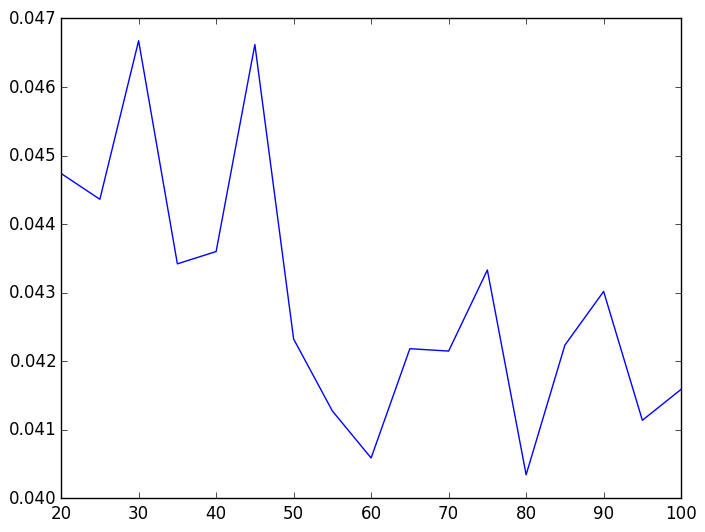

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x327041990>

In [45]:
using PyPlot
C_Julia2 = LinearAlgebra.CholeskyModule.cholBlocked!(copy(A), Val{:L}, 10)
tt = Float64[]
for b in 20:5:100
    push!(tt, minimum(Float64[(gc(); @elapsed LinearAlgebra.CholeskyModule.cholBlocked!(copy(A), Val{:L}, b)) for i = 1:5]))
end
plot(20:5:100, tt)

#####Symmetric tridiagonal eigenproblem
When only values are requested, LAPACK uses a square root free QR algorithm described in Parlett's "The Symmetric Eigenvalue Problem". No BLAS3 optimization is possible for this algorithm.

In [9]:
n = 2000
A = SymTridiagonal(2randn(n), Float64[rand(Chi(i)) for i = n-1:-1:1]) # Hermite ensemple

# LAPACK:
eigvals(A)
@time vals_LAPACK = eigvals(A)

# Pure Julia
LinearAlgebra.EigenSelfAdjoint.eigvals!(copy(A))
@time vals_Julia = LinearAlgebra.EigenSelfAdjoint.eigvals!(copy(A))
# @time vals_Julia = LinearAlgebra.EigenSelfAdjoint.eigvals!(big(A), BigFloat("1e-500")) # use smaller n for this option.

@show Float64(norm(vals_LAPACK - vals_Julia))
;

elapsed time: 0.08689491 seconds (63 kB allocated)
elapsed time: 0.067619335 seconds (31 kB allocated)
Float64(norm(vals_LAPACK - vals_Julia)) = 9.747047234644617e-11


##Parallel linear algebra
- Distributed machines
- Libraries
- Threading
- Julia HPC

###Distributed Arrays

In [10]:
rmprocs(workers())
addprocs(4)
@everywhere using DistributedArrays
;

In [11]:
A = drandn(10000, 10000)

10000x10000 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
  1.57508     0.260124    1.38756    …  -0.247866    0.55253    -0.182612 
  0.118672    0.293676   -0.550505       0.497556    0.501465    1.08893  
 -0.0655339  -0.199748   -0.682365      -0.147287    1.34312    -0.760768 
 -0.0367901   0.128558   -1.55301       -1.27129    -1.58649     0.0511057
 -1.59606     0.186729   -0.0681232      0.469997   -0.428853   -1.23812  
  0.640557   -0.764092    1.30184    …  -0.0218993  -0.689255   -0.590049 
  0.546294   -0.284476   -0.479754      -0.0504806  -0.213545    0.434343 
 -0.867841    0.0952929   1.26215       -0.118773   -0.253901   -0.347077 
  0.843538    0.927603    0.206916      -0.351399    0.760168    0.978682 
  0.642559    0.429471    0.353492       1.27884    -1.6201     -0.582553 
 -2.16565    -1.25054    -0.211733   …  -0.0785485  -0.0914334  -0.402921 
  1.47553     0.408073    1.44798        0.105171    0.373992   -1.55591  
 -0.70736    -0.567213    0.197668

In [12]:
fieldnames(A)

5-element Array{Symbol,1}:
 :dims   
 :chunks 
 :pmap   
 :indexes
 :cuts   

In [13]:
reducedim(+, A, 2)

10000x1 DistributedArrays.DArray{Float64,2,Array{Float64,2}}:
  155.247  
   21.3457 
  -84.1103 
   32.4624 
  100.383  
  194.676  
  -20.7796 
  -46.748  
  -36.0814 
   23.63   
   82.0796 
   97.1172 
  -20.3241 
    ⋮      
  -40.685  
   -6.80233
   81.6543 
   21.4093 
   39.0437 
  128.726  
 -132.78   
   17.4816 
   -9.65989
   39.4961 
    2.58906
   43.0252 

###Libraries
- ScaLAPACK
- Elemental (why we are here!)
- Julia based?

###Threading
- Work in progress, but a big task.

###HPC
- Cray in Switzerland
- Intel HPC group
- PowerPC